In [51]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import coint

# Stock Selection via Correlation Matrix Heatmap

[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed
C:\Users\Filtrum\AppData\Local\Temp\ipykernel_23192\2532440259.py:18: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns[sector] = data.pct_change().dropna()


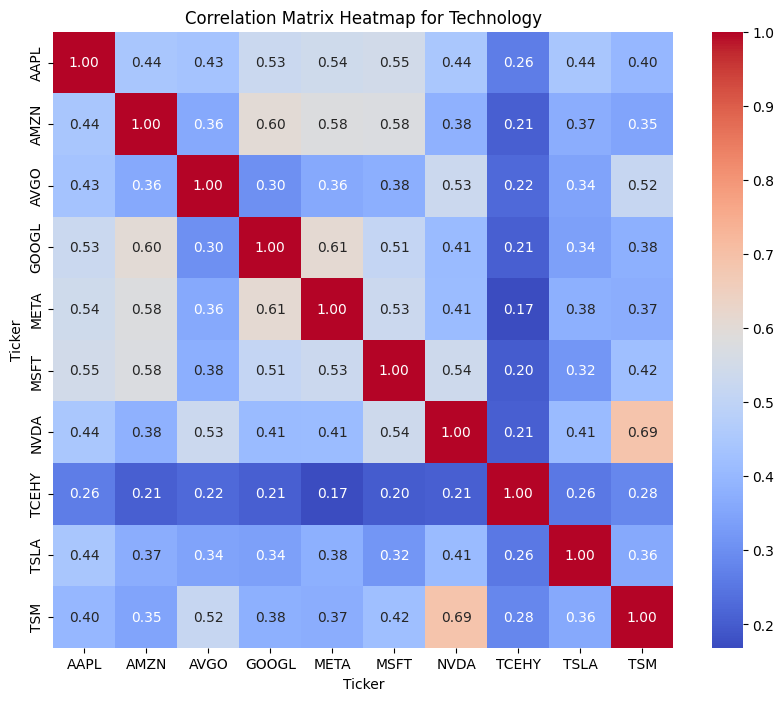


High correlation pairs in Technology: []


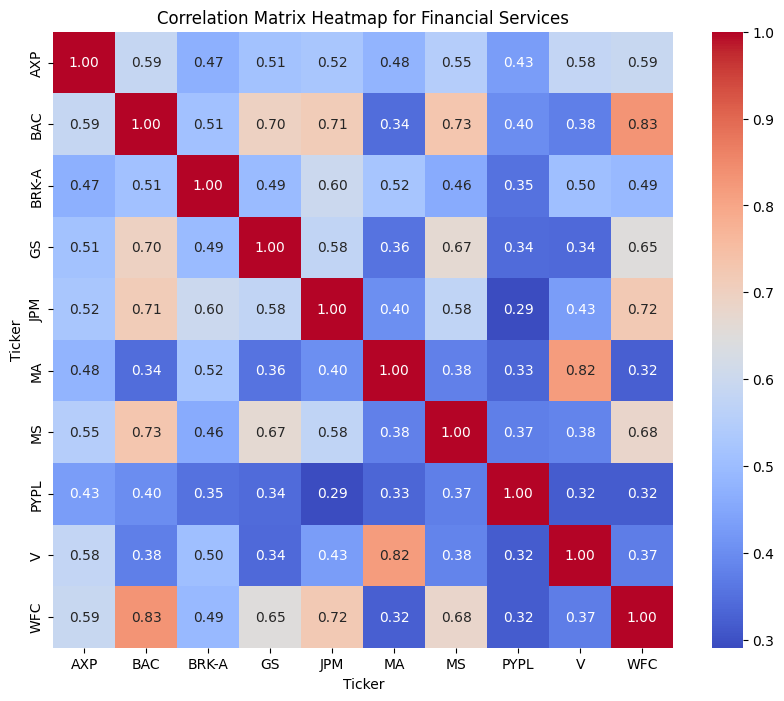


High correlation pairs in Financial Services: [('BAC', 'WFC'), ('MA', 'V')]


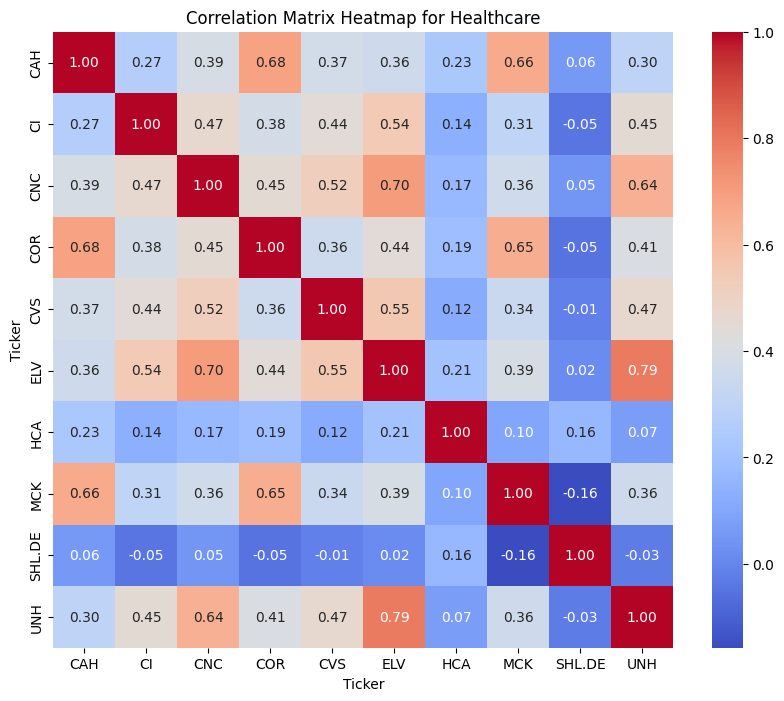


High correlation pairs in Healthcare: []


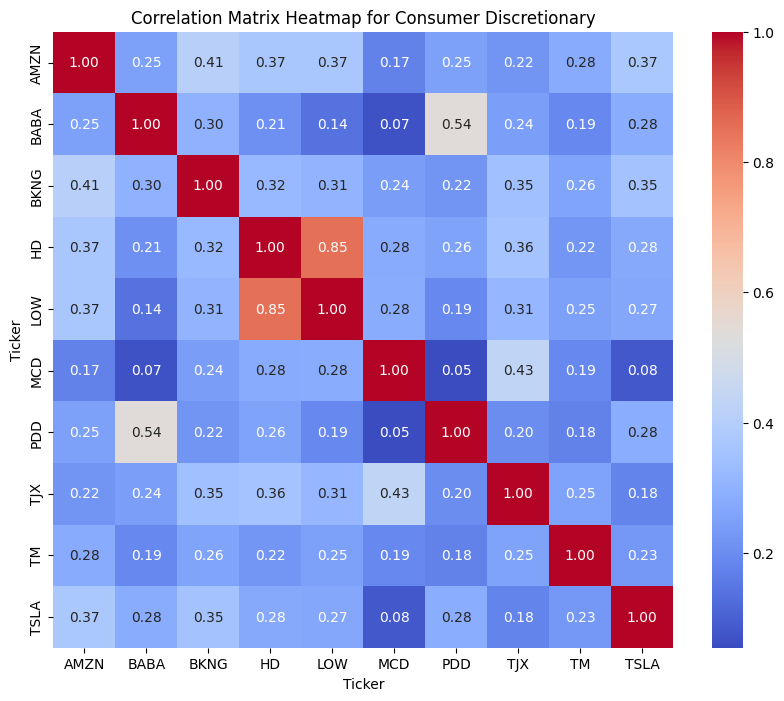


High correlation pairs in Consumer Discretionary: [('HD', 'LOW')]


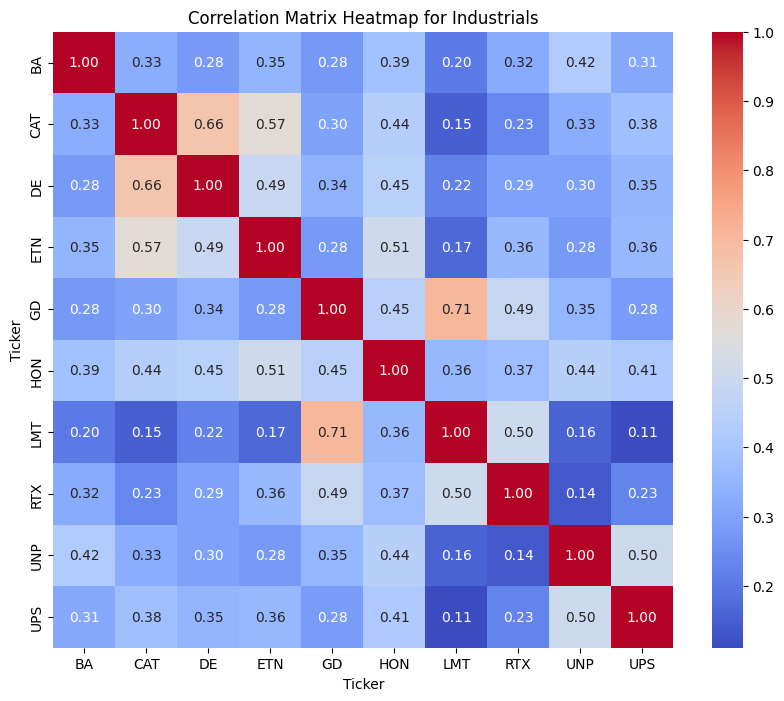


High correlation pairs in Industrials: []


In [52]:
# Define the top stocks in each sector by market
sectors = {
    'Technology': ['AAPL', 'MSFT', 'GOOGL', 'META', 'TSLA', 'NVDA', 'AVGO', 'TSM', 'TCEHY', 'AMZN'],
    'Financial Services': ['JPM', 'BRK-A', 'V', 'MA', 'WFC', 'BAC', 'MS', 'PYPL', 'GS', 'AXP'],
    'Healthcare': ['ELV', 'UNH', 'HCA', 'CI', 'MCK', 'CVS', 'SHL.DE', 'COR', 'CNC', 'CAH'],
    'Consumer Discretionary': ['AMZN', 'TSLA', 'HD', 'TM', 'MCD', 'BABA', 'LOW', 'PDD', 'TJX', 'BKNG'],
    'Industrials': ['DE', 'HON', 'UNP', 'UPS', 'CAT', 'BA', 'RTX', 'LMT', 'GD', 'ETN']
}

# Fetch historical stock price data
stock_data = {}
for sector, stocks in sectors.items():
    stock_data[sector] = yf.download(stocks, start='2023-01-01', end='2023-12-31')['Adj Close']

# Calculate daily returns
returns = {}
for sector, data in stock_data.items():
    returns[sector] = data.pct_change().dropna()

# Compute the correlation matrix for each sector
correlation_matrices = {}
for sector, returns_data in returns.items():
    correlation_matrices[sector] = returns_data.corr()

# Visualize the correlation matrices as heatmaps
for sector, correlation_matrix in correlation_matrices.items():
    # Create a heatmap of the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(f'Correlation Matrix Heatmap for {sector}')
    plt.show()
    print()
    
# Print pairs with correlation > 0.8
    high_correlation_pairs = [(stock1, stock2) for stock1 in correlation_matrix.columns for stock2 in correlation_matrix.columns if stock1 < stock2 and correlation_matrix.loc[stock1, stock2] > 0.8]
    print(f'High correlation pairs in {sector}: {high_correlation_pairs}')

# Cointegration and Stationarity Test

In [53]:
import pandas as pd
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm

# Identify pairs with correlation > 0.8
cointegration_pairs = {}
for sector, corr_matrix in correlation_matrices.items():
    pairs = []
    for stock1 in corr_matrix.columns:
        for stock2 in corr_matrix.columns:
            if stock1 != stock2 and corr_matrix[stock1][stock2] > 0.8:
                pairs.append((stock1, stock2))
    cointegration_pairs[sector] = pairs

# Perform ADF stationarity tests followed by cointegration tests
adf_results = {}
cointegration_results = {}
for sector, pairs in cointegration_pairs.items():
    adf_results[sector] = {}
    cointegration_results[sector] = {}
    for stock1, stock2 in pairs:
        # ADF stationarity tests
        adf_stock1 = ts.adfuller(returns[sector][stock1])
        adf_stock2 = ts.adfuller(returns[sector][stock2])

        adf_results[sector][(stock1, stock2)] = {
            'ADF_Stat_Stock1': adf_stock1[0],
            'ADF_Stat_Stock2': adf_stock2[0],
            'ADF_Stationarity_Stock1': adf_stock1[1] < 0.05,
            'ADF_Stationarity_Stock2': adf_stock2[1] < 0.05,
            'ADF_p_value_stock1': adf_stock1[1],
            'ADF_p_value_stock2': adf_stock2[1]
        }

        # Cointegration tests
        coint_score, p_value_coint, critical_values = sm.tsa.stattools.coint(returns[sector][stock1], returns[sector][stock2])

        cointegration_results[sector][(stock1, stock2)] = {
            'Cointegration_Stat': coint_score,
            'Cointegration_p_value': p_value_coint,
            'Cointegration': p_value_coint < 0.05,
        }

# Convert ADF results dictionary to a DataFrame
adf_df_list = []
for sector, tests in adf_results.items():
    for pair, result in tests.items():
        adf_df_list.append({
            'Sector': sector,
            'Pair': pair,
            'ADF_Stat_Stock1': result['ADF_Stat_Stock1'],
            'ADF_Stat_Stock2': result['ADF_Stat_Stock2'],
            'ADF_p_value_stock1': result['ADF_p_value_stock1'],
            'ADF_p_value_stock2': result['ADF_p_value_stock2'],
            'ADF_Stationarity_Stock1': result['ADF_Stationarity_Stock1'],
            'ADF_Stationarity_Stock2': result['ADF_Stationarity_Stock2'],
        })
adf_df = pd.DataFrame(adf_df_list)

# Convert cointegration results dictionary to a DataFrame
cointegration_df_list = []
for sector, tests in cointegration_results.items():
    for pair, result in tests.items():
        cointegration_df_list.append({
            'Sector': sector,
            'Pair': pair,
            'Cointegration': result['Cointegration_Stat'],
            'Cointegration_p_value': result['Cointegration_p_value'],
            'Cointegrated': result['Cointegration']
        })
cointegration_df = pd.DataFrame(cointegration_df_list)

# Print the ADF results DataFrame
print("ADF Results:")
print(adf_df)

# Print the cointegration results DataFrame
print("\nCointegration Results:")
print(cointegration_df)

ADF Results:
                   Sector        Pair  ADF_Stat_Stock1  ADF_Stat_Stock2  \
0      Financial Services  (BAC, WFC)       -13.865826        -9.238028   
1      Financial Services     (MA, V)       -15.898216       -10.468862   
2      Financial Services     (V, MA)       -10.468862       -15.898216   
3      Financial Services  (WFC, BAC)        -9.238028       -13.865826   
4  Consumer Discretionary   (HD, LOW)       -11.891555        -6.861978   
5  Consumer Discretionary   (LOW, HD)        -6.861978       -11.891555   

   ADF_p_value_stock1  ADF_p_value_stock2  ADF_Stationarity_Stock1  \
0        6.600628e-26        1.610591e-15                     True   
1        8.387689e-29        1.300054e-18                     True   
2        1.300054e-18        8.387689e-29                     True   
3        1.610591e-15        6.600628e-26                     True   
4        5.852387e-22        1.593923e-09                     True   
5        1.593923e-09        5.852387e-22

Visualize spreads from 2024-01-01 to 2024-08-01, set buy and sell signals when spread deviates from mean by +1 and -1 respectively.

[*********************100%%**********************]  6 of 6 completed


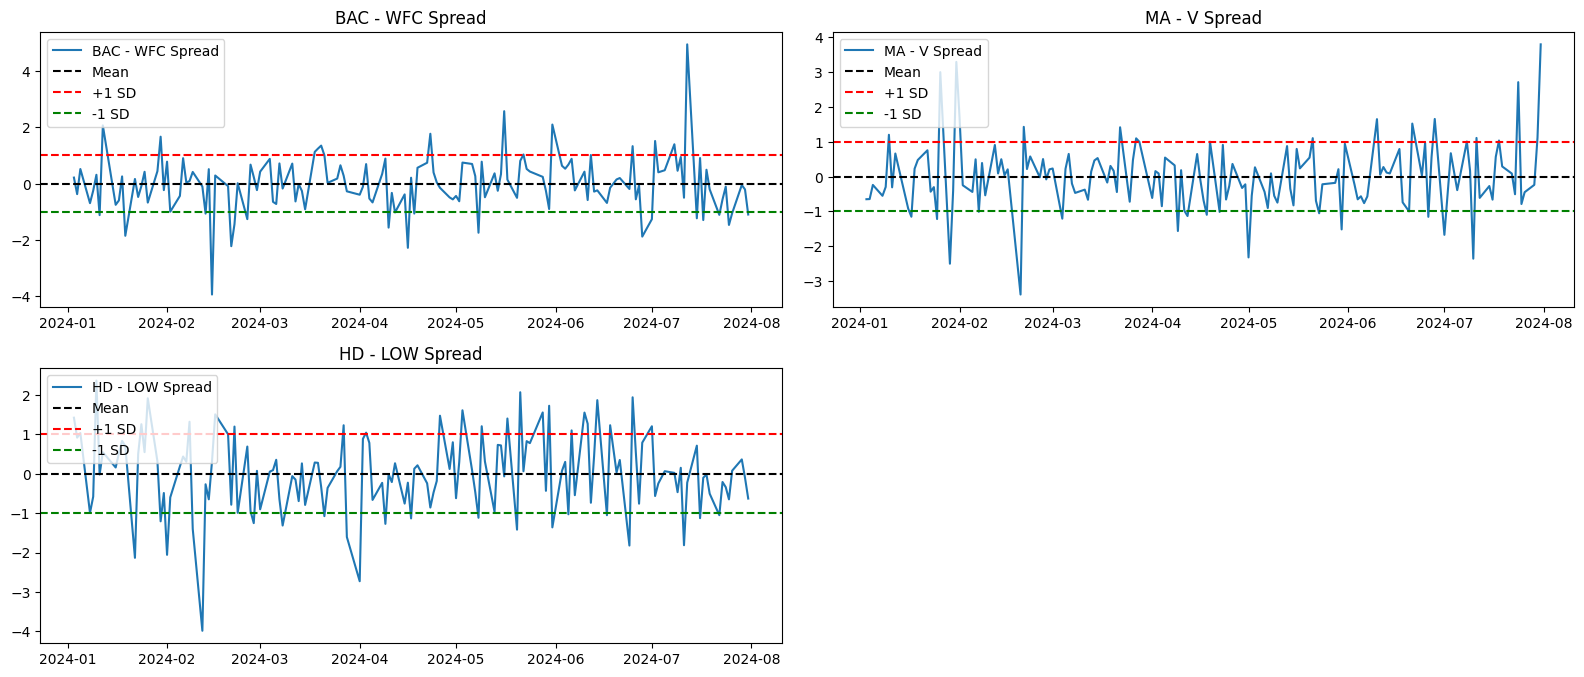

In [54]:
# Selected pairs with correlation > 0.8
selected_pairs = ['BAC', 'WFC', 'MA', 'V', 'HD', 'LOW']

# Fetch historical stock price data for the selected pairs
stock_data = yf.download(selected_pairs, start='2024-01-01', end='2024-08-01')['Adj Close']

# Calculate daily returns
returns = stock_data.pct_change().dropna()

# Calculate spread for each pair
spread_data = {}
for i in range(0, len(selected_pairs), 2):
    pair = (selected_pairs[i], selected_pairs[i+1])
    stock1, stock2 = pair
    spread = returns[stock1] - returns[stock2]
    spread_data[pair] = spread

# Compute mean and standard deviation of each spread
spread_stats = {}
for pair, spread in spread_data.items():
    mean_spread = spread.mean()
    std_spread = spread.std()
    spread_stats[pair] = (mean_spread, std_spread)

# Trading strategy
threshold = 1  
trade_signals = {}
for pair, spread in spread_data.items():
    mean_spread, std_spread = spread_stats[pair]
    upper_threshold = mean_spread + threshold * std_spread
    lower_threshold = mean_spread - threshold * std_spread
    long_entries = spread[spread >= upper_threshold]
    short_entries = spread[spread <= lower_threshold]
    trade_signals[pair] = (long_entries, short_entries)

# Plot the spread of selected pairs with normalized y-axis
plt.figure(figsize=(16, 10))
for i, (pair, spread) in enumerate(spread_data.items(), 1):
    plt.subplot(len(selected_pairs)//2, 2, i)
    normalized_spread = (spread - spread_stats[pair][0]) / spread_stats[pair][1]
    plt.plot(spread.index, normalized_spread, label=f'{pair[0]} - {pair[1]} Spread')
    plt.axhline(0, color='k', linestyle='--', label='Mean')
    plt.axhline(1, color='r', linestyle='--', label='+1 SD')
    plt.axhline(-1, color='g', linestyle='--', label='-1 SD')
    plt.legend(loc='upper left') 
    plt.title(f'{pair[0]} - {pair[1]} Spread')
plt.tight_layout()
plt.show()

Plot equity curves of trading strategy

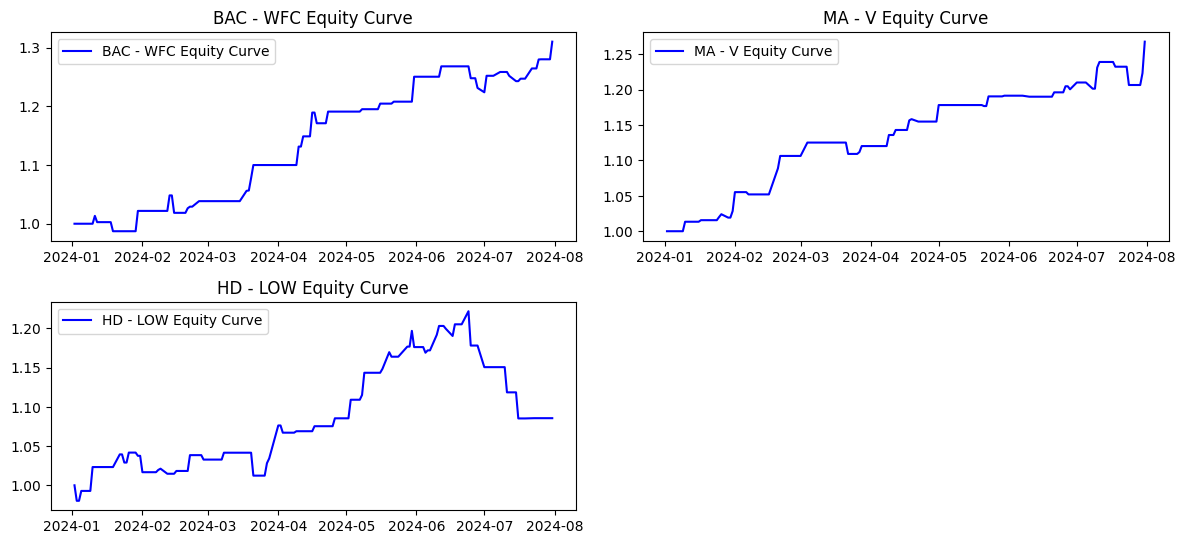

[*********************100%%**********************]  1 of 1 completed

BAC - WFC Percentage Return: 31.06%
MA - V Percentage Return: 26.80%
HD - LOW Percentage Return: 8.56%
Portfolio Return with Equal Weights (Average of Pair Returns): 22.14%
S&P 500 Total Return: 16.43%


In [55]:
# Simulate trading and create equity curves
equity_curves = {}
for pair, (long_entries, short_entries) in trade_signals.items():
    equity_curve = pd.Series(index=stock_data.index)
    equity_curve.iloc[0] = 1 
    for date in stock_data.index[1:]:
        if date in long_entries.index:
            equity_curve.loc[date] = equity_curve.shift(1).loc[date] * (1 + returns[pair[0]].loc[date])
        elif date in short_entries.index:
            equity_curve.loc[date] = equity_curve.shift(1).loc[date] * (1 - returns[pair[0]].loc[date])
        else:
            equity_curve.loc[date] = equity_curve.shift(1).loc[date]
    equity_curves[pair] = equity_curve

# Plot the equity curves for each pair
plt.figure(figsize=(12, 8))
for i, (pair, equity_curve) in enumerate(equity_curves.items(), 1):
    plt.subplot(len(selected_pairs)//2, 2, i)
    plt.plot(equity_curve.index, equity_curve, label=f'{pair[0]} - {pair[1]} Equity Curve', color='b')
    plt.legend()
    plt.title(f'{pair[0]} - {pair[1]} Equity Curve')
plt.tight_layout()
plt.show()
plt.show()

# Calculate percentage return of each pair
pair_returns = {}
for pair, equity_curve in equity_curves.items():
    pair_return = (equity_curve.iloc[-1] - 1) * 100  
    pair_returns[pair] = pair_return
    print(f'{pair[0]} - {pair[1]} Percentage Return: {pair_return:.2f}%')

average_return = np.mean(list(pair_returns.values()))

# Calculate the total return of equal weight portfolio
portfolio_return = average_return
print(f'Portfolio Return with Equal Weights (Average of Pair Returns): {portfolio_return:.2f}%')

# Fetch historical data for the S&P 500 index
sp500_data = yf.download('^GSPC', start='2024-01-01', end='2024-08-01')['Adj Close']

# Calculate daily returns
sp500_returns = sp500_data.pct_change().dropna()

# Calculate total S&P500 return over the same period
total_return = (sp500_data.iloc[-1] / sp500_data.iloc[0] - 1) * 100

print(f'S&P 500 Total Return: {total_return:.2f}%')